In [2]:

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
#이미지 저장될 폴더없을시 만들어주기
import os
if not os.path.exists("./gan_images"):
    os.makedirs("./gan_images")
np.random.seed(3)
tf.random.set_seed(3)

In [6]:
# 생성자 모델 만둘가
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

In [ ]:
#Activation function 

In [7]:
# 판별자 모델 만들기
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [8]:
# 생성자와 판별자 모델을 연결시키는 gan 모델 만들기 
ginput = Input(shape=(100,))
 
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [22]:
# 신경망을 실행시키는 함수 만들기
def gan_train(epoch, batch_size, saving_interval):
    ## MNIST 데이터 불러오기
# 앞서 불러온 MNIST를 다시 이용, 테스트 과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 호출
    (X_train, _), (_, _) = mnist.load_data()  
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    # 127.5를 빼준 뒤 127.5로 나눠서 -1~1사이의 값으로 바꿈
    X_train = (X_train - 127.5) / 127.5  
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
 
    for i in range(epoch):
      # 실제 데이터를 판별자에 입력
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)
 
        # 가상 이미지를 판별자에 입력
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
 
        # 판별자와 생성자의 오차 계산
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)
    # 중간 과정을 이미지로 저장하는 부분. 정해진 인터벌만큼 학습되면 그때 만든 이미지를 gan_images 폴더에 저장하라는 뜻. 이 코드는 본 장의 주된 목표와는 관계가 없어서 소스 코드만 소개한다
 
        if i % saving_interval == 0:
            # r, c = 5, 5
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)
 
            # Rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5
 
            fig, axs = plt.subplots(5, 5)  
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count += 1
                    fig.savefig("gan_images/gan_mnist_%d.png" % i)

epoch:0  d_loss:0.3530  g_loss:3.6536
epoch:1  d_loss:2.3303  g_loss:0.6488
epoch:2  d_loss:0.4452  g_loss:0.8782
epoch:3  d_loss:1.8089  g_loss:9.6504
epoch:4  d_loss:0.1578  g_loss:20.1037
epoch:5  d_loss:0.0047  g_loss:22.6657
epoch:6  d_loss:0.0016  g_loss:11.9265
epoch:7  d_loss:0.0000  g_loss:1.0029
epoch:8  d_loss:0.0655  g_loss:0.0000
epoch:9  d_loss:1.3890  g_loss:0.0000
epoch:10  d_loss:0.7110  g_loss:4.1115
epoch:11  d_loss:4.0592  g_loss:0.0001
epoch:12  d_loss:1.6333  g_loss:0.0000
epoch:13  d_loss:0.8202  g_loss:0.0201
epoch:14  d_loss:0.0248  g_loss:5.5915
epoch:15  d_loss:0.0067  g_loss:13.9735
epoch:16  d_loss:0.0580  g_loss:17.6198
epoch:17  d_loss:0.1715  g_loss:18.4591
epoch:18  d_loss:0.5714  g_loss:15.4837
epoch:19  d_loss:1.0821  g_loss:12.4422
epoch:20  d_loss:2.3707  g_loss:11.6679
epoch:21  d_loss:1.1990  g_loss:17.6095
epoch:22  d_loss:3.1232  g_loss:9.5154
epoch:23  d_loss:0.7083  g_loss:9.4529
epoch:24  d_loss:0.0041  g_loss:17.6079
epoch:25  d_loss:1.5017 

epoch:207  d_loss:0.1482  g_loss:2.4943
epoch:208  d_loss:0.3487  g_loss:1.4632
epoch:209  d_loss:0.1453  g_loss:1.4955
epoch:210  d_loss:0.2834  g_loss:1.9467
epoch:211  d_loss:0.4361  g_loss:1.6427
epoch:212  d_loss:0.4550  g_loss:1.7848
epoch:213  d_loss:0.3174  g_loss:2.2175
epoch:214  d_loss:0.1939  g_loss:2.2484
epoch:215  d_loss:0.4438  g_loss:2.1173
epoch:216  d_loss:0.3301  g_loss:1.7984
epoch:217  d_loss:0.4079  g_loss:1.1869
epoch:218  d_loss:0.3648  g_loss:2.1199
epoch:219  d_loss:0.3523  g_loss:2.7158
epoch:220  d_loss:0.3153  g_loss:1.7805
epoch:221  d_loss:0.6390  g_loss:1.1049
epoch:222  d_loss:0.3302  g_loss:1.6497
epoch:223  d_loss:0.1956  g_loss:1.9698
epoch:224  d_loss:0.2528  g_loss:1.4293
epoch:225  d_loss:0.3883  g_loss:1.5493
epoch:226  d_loss:0.2804  g_loss:1.7498
epoch:227  d_loss:0.3422  g_loss:2.0417
epoch:228  d_loss:0.3686  g_loss:1.7633
epoch:229  d_loss:0.2972  g_loss:1.9369
epoch:230  d_loss:0.3200  g_loss:1.7848
epoch:231  d_loss:0.5397  g_loss:1.5787


epoch:412  d_loss:0.4791  g_loss:2.3530
epoch:413  d_loss:0.3919  g_loss:2.4233
epoch:414  d_loss:0.4895  g_loss:1.9647
epoch:415  d_loss:0.3993  g_loss:2.0446
epoch:416  d_loss:0.5215  g_loss:1.8737
epoch:417  d_loss:0.3827  g_loss:2.3644
epoch:418  d_loss:0.4377  g_loss:2.4544
epoch:419  d_loss:0.2960  g_loss:2.0710
epoch:420  d_loss:0.4043  g_loss:2.4739
epoch:421  d_loss:0.3765  g_loss:2.3931
epoch:422  d_loss:0.4682  g_loss:1.7318
epoch:423  d_loss:0.5635  g_loss:1.4059
epoch:424  d_loss:0.4391  g_loss:2.0700
epoch:425  d_loss:0.4303  g_loss:1.9973
epoch:426  d_loss:0.4047  g_loss:2.4790
epoch:427  d_loss:0.4440  g_loss:2.2919
epoch:428  d_loss:0.5165  g_loss:1.7750
epoch:429  d_loss:0.3466  g_loss:2.4480
epoch:430  d_loss:0.6052  g_loss:2.0266
epoch:431  d_loss:0.5698  g_loss:1.5333
epoch:432  d_loss:0.4658  g_loss:1.7711
epoch:433  d_loss:0.5537  g_loss:2.1269
epoch:434  d_loss:0.4493  g_loss:2.7488
epoch:435  d_loss:0.4182  g_loss:2.3944
epoch:436  d_loss:0.4815  g_loss:1.9342


epoch:617  d_loss:0.3059  g_loss:2.1982
epoch:618  d_loss:0.4005  g_loss:1.8412
epoch:619  d_loss:0.3415  g_loss:1.7677
epoch:620  d_loss:0.3459  g_loss:2.5922
epoch:621  d_loss:0.4228  g_loss:2.6404
epoch:622  d_loss:0.4246  g_loss:2.0358
epoch:623  d_loss:0.3274  g_loss:2.0630
epoch:624  d_loss:0.6027  g_loss:1.7628
epoch:625  d_loss:0.3070  g_loss:2.8648
epoch:626  d_loss:0.3269  g_loss:2.6416
epoch:627  d_loss:0.3841  g_loss:3.0197
epoch:628  d_loss:0.4351  g_loss:2.2890
epoch:629  d_loss:0.3955  g_loss:2.2513
epoch:630  d_loss:0.3555  g_loss:1.9233
epoch:631  d_loss:0.2655  g_loss:2.4653
epoch:632  d_loss:0.3014  g_loss:2.1397
epoch:633  d_loss:0.3504  g_loss:2.7153
epoch:634  d_loss:0.3009  g_loss:2.5236
epoch:635  d_loss:0.5052  g_loss:2.2890
epoch:636  d_loss:0.4476  g_loss:2.3860
epoch:637  d_loss:0.5575  g_loss:1.9226
epoch:638  d_loss:0.3698  g_loss:2.7487
epoch:639  d_loss:0.2997  g_loss:3.2157
epoch:640  d_loss:0.6475  g_loss:2.1697
epoch:641  d_loss:0.3303  g_loss:1.5729


epoch:822  d_loss:0.4009  g_loss:1.7199
epoch:823  d_loss:0.3668  g_loss:2.3323
epoch:824  d_loss:0.3114  g_loss:2.3385
epoch:825  d_loss:0.3357  g_loss:2.1473
epoch:826  d_loss:0.3347  g_loss:2.0820
epoch:827  d_loss:0.4093  g_loss:2.2072
epoch:828  d_loss:0.4345  g_loss:1.5934
epoch:829  d_loss:0.3719  g_loss:1.7319
epoch:830  d_loss:0.2857  g_loss:2.4737
epoch:831  d_loss:0.3512  g_loss:2.2551
epoch:832  d_loss:0.4142  g_loss:2.2815
epoch:833  d_loss:0.3827  g_loss:2.1418
epoch:834  d_loss:0.3715  g_loss:1.7004
epoch:835  d_loss:0.2649  g_loss:1.8529
epoch:836  d_loss:0.3031  g_loss:2.0159
epoch:837  d_loss:0.2450  g_loss:2.9028
epoch:838  d_loss:0.3336  g_loss:3.1582
epoch:839  d_loss:0.1931  g_loss:2.7617
epoch:840  d_loss:0.2747  g_loss:2.5362
epoch:841  d_loss:0.2745  g_loss:2.1575
epoch:842  d_loss:0.3421  g_loss:1.7700
epoch:843  d_loss:0.1556  g_loss:2.2366
epoch:844  d_loss:0.2776  g_loss:2.3664
epoch:845  d_loss:0.3546  g_loss:2.8301
epoch:846  d_loss:0.2938  g_loss:2.9080


epoch:1027  d_loss:0.3220  g_loss:3.3424
epoch:1028  d_loss:0.5766  g_loss:2.4117
epoch:1029  d_loss:0.4509  g_loss:2.3161
epoch:1030  d_loss:0.3398  g_loss:2.0431
epoch:1031  d_loss:0.5592  g_loss:1.7857
epoch:1032  d_loss:0.4793  g_loss:1.8070
epoch:1033  d_loss:0.3383  g_loss:2.8302
epoch:1034  d_loss:0.5923  g_loss:2.4460
epoch:1035  d_loss:0.5979  g_loss:1.7018
epoch:1036  d_loss:0.5631  g_loss:1.9006
epoch:1037  d_loss:0.6692  g_loss:1.9690
epoch:1038  d_loss:0.6099  g_loss:1.8484
epoch:1039  d_loss:0.5260  g_loss:2.2339
epoch:1040  d_loss:0.6403  g_loss:1.8631
epoch:1041  d_loss:0.6518  g_loss:1.4946
epoch:1042  d_loss:0.7073  g_loss:1.6938
epoch:1043  d_loss:0.7879  g_loss:1.3096
epoch:1044  d_loss:0.6229  g_loss:2.0761
epoch:1045  d_loss:0.6391  g_loss:1.6006
epoch:1046  d_loss:0.7633  g_loss:1.3420
epoch:1047  d_loss:0.6667  g_loss:1.1166
epoch:1048  d_loss:0.6292  g_loss:1.2420
epoch:1049  d_loss:0.5641  g_loss:1.4583
epoch:1050  d_loss:0.4214  g_loss:2.0396
epoch:1051  d_lo

epoch:1227  d_loss:0.7116  g_loss:1.8282
epoch:1228  d_loss:0.4430  g_loss:2.1062
epoch:1229  d_loss:0.5116  g_loss:1.9950
epoch:1230  d_loss:0.6220  g_loss:1.8671
epoch:1231  d_loss:0.6277  g_loss:1.6306
epoch:1232  d_loss:0.5253  g_loss:1.7031
epoch:1233  d_loss:0.6159  g_loss:1.6687
epoch:1234  d_loss:0.6266  g_loss:1.8538
epoch:1235  d_loss:0.4306  g_loss:2.1097
epoch:1236  d_loss:0.5431  g_loss:2.0191
epoch:1237  d_loss:0.5089  g_loss:1.7362
epoch:1238  d_loss:0.5401  g_loss:1.5082
epoch:1239  d_loss:0.6539  g_loss:1.5274
epoch:1240  d_loss:0.5782  g_loss:1.9638
epoch:1241  d_loss:0.4271  g_loss:2.0964
epoch:1242  d_loss:0.4726  g_loss:2.2109
epoch:1243  d_loss:0.3573  g_loss:2.0572
epoch:1244  d_loss:0.3413  g_loss:2.1181
epoch:1245  d_loss:0.2703  g_loss:2.2918
epoch:1246  d_loss:0.4824  g_loss:1.8696
epoch:1247  d_loss:0.3039  g_loss:2.1209
epoch:1248  d_loss:0.4123  g_loss:1.9531
epoch:1249  d_loss:0.3284  g_loss:2.2612
epoch:1250  d_loss:0.4818  g_loss:2.1199
epoch:1251  d_lo

epoch:1427  d_loss:0.4425  g_loss:1.4427
epoch:1428  d_loss:0.5454  g_loss:1.7993
epoch:1429  d_loss:0.5507  g_loss:1.8270
epoch:1430  d_loss:0.6618  g_loss:1.6158
epoch:1431  d_loss:0.5411  g_loss:1.2078
epoch:1432  d_loss:0.4234  g_loss:1.4755
epoch:1433  d_loss:0.4643  g_loss:1.6668
epoch:1434  d_loss:0.3253  g_loss:2.2117
epoch:1435  d_loss:0.4453  g_loss:2.1914
epoch:1436  d_loss:0.4750  g_loss:2.0355
epoch:1437  d_loss:0.3728  g_loss:1.8306
epoch:1438  d_loss:0.4353  g_loss:1.8006
epoch:1439  d_loss:0.3288  g_loss:2.2703
epoch:1440  d_loss:0.2664  g_loss:2.5671
epoch:1441  d_loss:0.6120  g_loss:2.1577
epoch:1442  d_loss:0.4930  g_loss:2.1083
epoch:1443  d_loss:0.2686  g_loss:2.2529
epoch:1444  d_loss:0.6470  g_loss:2.0188
epoch:1445  d_loss:0.6420  g_loss:1.9771
epoch:1446  d_loss:0.7113  g_loss:1.4968
epoch:1447  d_loss:0.5523  g_loss:1.7216
epoch:1448  d_loss:0.6634  g_loss:1.6896
epoch:1449  d_loss:0.6440  g_loss:1.5110
epoch:1450  d_loss:0.4868  g_loss:1.7864
epoch:1451  d_lo

epoch:1627  d_loss:0.5303  g_loss:1.3614
epoch:1628  d_loss:0.5820  g_loss:1.2547
epoch:1629  d_loss:0.5380  g_loss:1.2296
epoch:1630  d_loss:0.2962  g_loss:1.4972
epoch:1631  d_loss:0.3771  g_loss:1.7261
epoch:1632  d_loss:0.5490  g_loss:1.5599
epoch:1633  d_loss:0.5599  g_loss:1.5241
epoch:1634  d_loss:0.6302  g_loss:1.5564
epoch:1635  d_loss:0.4779  g_loss:1.5947
epoch:1636  d_loss:0.4762  g_loss:1.4661
epoch:1637  d_loss:0.5307  g_loss:1.5958
epoch:1638  d_loss:0.3876  g_loss:1.3892
epoch:1639  d_loss:0.5443  g_loss:1.6886
epoch:1640  d_loss:0.4221  g_loss:1.6336
epoch:1641  d_loss:0.5529  g_loss:1.7011
epoch:1642  d_loss:0.6008  g_loss:1.3923
epoch:1643  d_loss:0.6497  g_loss:1.3317
epoch:1644  d_loss:0.6663  g_loss:1.3358
epoch:1645  d_loss:0.5952  g_loss:1.2782
epoch:1646  d_loss:0.6021  g_loss:1.2318
epoch:1647  d_loss:0.6232  g_loss:1.4763
epoch:1648  d_loss:0.6103  g_loss:1.4959
epoch:1649  d_loss:0.5138  g_loss:1.7979
epoch:1650  d_loss:0.7844  g_loss:1.2876
epoch:1651  d_lo

epoch:1827  d_loss:0.5880  g_loss:1.3261
epoch:1828  d_loss:0.5317  g_loss:1.5037
epoch:1829  d_loss:0.5774  g_loss:1.3649
epoch:1830  d_loss:0.5527  g_loss:1.7293
epoch:1831  d_loss:0.4583  g_loss:1.8577
epoch:1832  d_loss:0.5490  g_loss:1.6769
epoch:1833  d_loss:0.5523  g_loss:1.4286
epoch:1834  d_loss:0.5751  g_loss:1.2314
epoch:1835  d_loss:0.6622  g_loss:1.4429
epoch:1836  d_loss:0.4278  g_loss:1.0487
epoch:1837  d_loss:0.4226  g_loss:1.6508
epoch:1838  d_loss:0.6194  g_loss:1.5259
epoch:1839  d_loss:0.4223  g_loss:1.3455
epoch:1840  d_loss:0.4997  g_loss:1.4206
epoch:1841  d_loss:0.4940  g_loss:1.5863
epoch:1842  d_loss:0.6340  g_loss:1.3599
epoch:1843  d_loss:0.5539  g_loss:1.1702
epoch:1844  d_loss:0.5407  g_loss:1.3339
epoch:1845  d_loss:0.5122  g_loss:1.4283
epoch:1846  d_loss:0.6525  g_loss:1.2506
epoch:1847  d_loss:0.5753  g_loss:1.2300
epoch:1848  d_loss:0.4790  g_loss:1.5028
epoch:1849  d_loss:0.5663  g_loss:1.7116
epoch:1850  d_loss:0.5568  g_loss:1.2057
epoch:1851  d_lo

epoch:2027  d_loss:0.6674  g_loss:1.3624
epoch:2028  d_loss:0.5118  g_loss:1.1963
epoch:2029  d_loss:0.4839  g_loss:1.4965
epoch:2030  d_loss:0.5996  g_loss:1.5725
epoch:2031  d_loss:0.5421  g_loss:1.4295
epoch:2032  d_loss:0.5258  g_loss:1.5852
epoch:2033  d_loss:0.6153  g_loss:1.4009
epoch:2034  d_loss:0.4217  g_loss:1.5293
epoch:2035  d_loss:0.5084  g_loss:1.7528
epoch:2036  d_loss:0.5492  g_loss:1.3150
epoch:2037  d_loss:0.4543  g_loss:1.4868
epoch:2038  d_loss:0.4505  g_loss:1.4274
epoch:2039  d_loss:0.4779  g_loss:1.4525
epoch:2040  d_loss:0.4768  g_loss:1.3076
epoch:2041  d_loss:0.3984  g_loss:1.6703
epoch:2042  d_loss:0.4678  g_loss:2.0662
epoch:2043  d_loss:0.4293  g_loss:2.0162
epoch:2044  d_loss:0.4473  g_loss:1.7490
epoch:2045  d_loss:0.6298  g_loss:1.4662
epoch:2046  d_loss:0.7373  g_loss:1.3769
epoch:2047  d_loss:0.5169  g_loss:1.3713
epoch:2048  d_loss:0.4684  g_loss:1.6319
epoch:2049  d_loss:0.5412  g_loss:1.8505
epoch:2050  d_loss:0.6784  g_loss:1.5971
epoch:2051  d_lo

epoch:2227  d_loss:0.5884  g_loss:1.4590
epoch:2228  d_loss:0.6173  g_loss:1.2681
epoch:2229  d_loss:0.5373  g_loss:1.5061
epoch:2230  d_loss:0.7283  g_loss:1.2548
epoch:2231  d_loss:0.7572  g_loss:1.2734
epoch:2232  d_loss:0.5461  g_loss:1.1265
epoch:2233  d_loss:0.6285  g_loss:1.2876
epoch:2234  d_loss:0.6024  g_loss:1.3538
epoch:2235  d_loss:0.5952  g_loss:1.5922
epoch:2236  d_loss:0.5736  g_loss:1.7054
epoch:2237  d_loss:0.5294  g_loss:1.5841
epoch:2238  d_loss:0.5757  g_loss:1.4345
epoch:2239  d_loss:0.5097  g_loss:1.2620
epoch:2240  d_loss:0.4796  g_loss:1.1560
epoch:2241  d_loss:0.4534  g_loss:1.8096
epoch:2242  d_loss:0.5980  g_loss:1.4187
epoch:2243  d_loss:0.6022  g_loss:1.3193
epoch:2244  d_loss:0.5661  g_loss:1.1486
epoch:2245  d_loss:0.6074  g_loss:1.4598
epoch:2246  d_loss:0.5533  g_loss:1.1328
epoch:2247  d_loss:0.5744  g_loss:1.3487
epoch:2248  d_loss:0.4855  g_loss:1.4564
epoch:2249  d_loss:0.5398  g_loss:1.5611
epoch:2250  d_loss:0.4480  g_loss:1.8789
epoch:2251  d_lo

epoch:2427  d_loss:0.5954  g_loss:1.3891
epoch:2428  d_loss:0.5436  g_loss:1.3766
epoch:2429  d_loss:0.6265  g_loss:1.2990
epoch:2430  d_loss:0.4856  g_loss:1.1399
epoch:2431  d_loss:0.5857  g_loss:0.9848
epoch:2432  d_loss:0.6139  g_loss:1.2981
epoch:2433  d_loss:0.5103  g_loss:1.2918
epoch:2434  d_loss:0.5009  g_loss:1.7560
epoch:2435  d_loss:0.4743  g_loss:1.5712
epoch:2436  d_loss:0.4876  g_loss:1.4365
epoch:2437  d_loss:0.5276  g_loss:1.3095
epoch:2438  d_loss:0.4915  g_loss:1.3240
epoch:2439  d_loss:0.5676  g_loss:1.9376
epoch:2440  d_loss:0.5563  g_loss:1.6452
epoch:2441  d_loss:0.5287  g_loss:1.5640
epoch:2442  d_loss:0.4107  g_loss:1.5950
epoch:2443  d_loss:0.4667  g_loss:1.5385
epoch:2444  d_loss:0.4011  g_loss:1.4673
epoch:2445  d_loss:0.4316  g_loss:1.8335
epoch:2446  d_loss:0.4625  g_loss:1.7283
epoch:2447  d_loss:0.4974  g_loss:1.8133
epoch:2448  d_loss:0.6530  g_loss:1.2469
epoch:2449  d_loss:0.4547  g_loss:1.3826
epoch:2450  d_loss:0.4797  g_loss:1.5043
epoch:2451  d_lo

epoch:2627  d_loss:0.5542  g_loss:1.4772
epoch:2628  d_loss:0.6109  g_loss:1.2480
epoch:2629  d_loss:0.4378  g_loss:1.7851
epoch:2630  d_loss:0.4404  g_loss:1.7251
epoch:2631  d_loss:0.4900  g_loss:1.7007
epoch:2632  d_loss:0.4578  g_loss:1.5368
epoch:2633  d_loss:0.3983  g_loss:1.7149
epoch:2634  d_loss:0.5313  g_loss:1.3772
epoch:2635  d_loss:0.7478  g_loss:1.1515
epoch:2636  d_loss:0.5715  g_loss:1.4066
epoch:2637  d_loss:0.4648  g_loss:1.4362
epoch:2638  d_loss:0.6093  g_loss:1.4213
epoch:2639  d_loss:0.5481  g_loss:1.6219
epoch:2640  d_loss:0.5142  g_loss:1.5130
epoch:2641  d_loss:0.5309  g_loss:1.6303
epoch:2642  d_loss:0.5324  g_loss:1.5277
epoch:2643  d_loss:0.6575  g_loss:1.4676
epoch:2644  d_loss:0.6016  g_loss:1.5069
epoch:2645  d_loss:0.5636  g_loss:1.4216
epoch:2646  d_loss:0.5269  g_loss:1.1767
epoch:2647  d_loss:0.4425  g_loss:1.2745
epoch:2648  d_loss:0.5852  g_loss:1.1895
epoch:2649  d_loss:0.6469  g_loss:1.3279
epoch:2650  d_loss:0.6623  g_loss:1.4144
epoch:2651  d_lo

epoch:2827  d_loss:0.4959  g_loss:1.5787
epoch:2828  d_loss:0.4926  g_loss:1.7634
epoch:2829  d_loss:0.4260  g_loss:1.3934
epoch:2830  d_loss:0.5384  g_loss:1.6860
epoch:2831  d_loss:0.4689  g_loss:1.8250
epoch:2832  d_loss:0.4292  g_loss:1.6902
epoch:2833  d_loss:0.4118  g_loss:1.7265
epoch:2834  d_loss:0.4215  g_loss:1.5290
epoch:2835  d_loss:0.5472  g_loss:1.6041
epoch:2836  d_loss:0.5522  g_loss:1.7928
epoch:2837  d_loss:0.6745  g_loss:1.7918
epoch:2838  d_loss:0.6424  g_loss:1.4735
epoch:2839  d_loss:0.5596  g_loss:1.6749
epoch:2840  d_loss:0.5418  g_loss:1.3820
epoch:2841  d_loss:0.6300  g_loss:1.4345
epoch:2842  d_loss:0.5361  g_loss:1.2274
epoch:2843  d_loss:0.5832  g_loss:1.2353
epoch:2844  d_loss:0.5646  g_loss:1.2050
epoch:2845  d_loss:0.6057  g_loss:1.3737
epoch:2846  d_loss:0.5055  g_loss:1.6719
epoch:2847  d_loss:0.5254  g_loss:1.5465
epoch:2848  d_loss:0.7567  g_loss:1.6935
epoch:2849  d_loss:0.6913  g_loss:1.3815
epoch:2850  d_loss:0.6117  g_loss:1.1112
epoch:2851  d_lo

epoch:3027  d_loss:0.4750  g_loss:1.5986
epoch:3028  d_loss:0.4682  g_loss:1.7483
epoch:3029  d_loss:0.4553  g_loss:1.6684
epoch:3030  d_loss:0.5511  g_loss:1.7896
epoch:3031  d_loss:0.3896  g_loss:1.6048
epoch:3032  d_loss:0.4367  g_loss:2.1958
epoch:3033  d_loss:0.5374  g_loss:1.9322
epoch:3034  d_loss:0.4928  g_loss:1.6153
epoch:3035  d_loss:0.3896  g_loss:1.8831
epoch:3036  d_loss:0.4510  g_loss:1.6955
epoch:3037  d_loss:0.4313  g_loss:1.8006
epoch:3038  d_loss:0.4339  g_loss:2.1460
epoch:3039  d_loss:0.4772  g_loss:2.2935
epoch:3040  d_loss:0.4292  g_loss:1.6621
epoch:3041  d_loss:0.3654  g_loss:1.8452
epoch:3042  d_loss:0.5714  g_loss:1.3488
epoch:3043  d_loss:0.5743  g_loss:1.6129
epoch:3044  d_loss:0.5848  g_loss:1.6027
epoch:3045  d_loss:0.5610  g_loss:1.7958
epoch:3046  d_loss:0.4871  g_loss:2.0359
epoch:3047  d_loss:0.4816  g_loss:1.9888
epoch:3048  d_loss:0.5441  g_loss:1.7855
epoch:3049  d_loss:0.5970  g_loss:1.3518
epoch:3050  d_loss:0.4960  g_loss:1.5219
epoch:3051  d_lo

epoch:3227  d_loss:0.3889  g_loss:1.9417
epoch:3228  d_loss:0.4672  g_loss:1.7965
epoch:3229  d_loss:0.4419  g_loss:1.5497
epoch:3230  d_loss:0.4831  g_loss:1.6974
epoch:3231  d_loss:0.4788  g_loss:1.1979
epoch:3232  d_loss:0.3349  g_loss:1.6719
epoch:3233  d_loss:0.4342  g_loss:1.5443
epoch:3234  d_loss:0.4243  g_loss:1.7110
epoch:3235  d_loss:0.4851  g_loss:1.8512
epoch:3236  d_loss:0.5094  g_loss:1.6698
epoch:3237  d_loss:0.4821  g_loss:1.4330
epoch:3238  d_loss:0.5029  g_loss:1.8730
epoch:3239  d_loss:0.3482  g_loss:1.6767
epoch:3240  d_loss:0.4343  g_loss:1.8976
epoch:3241  d_loss:0.4610  g_loss:1.5609
epoch:3242  d_loss:0.5496  g_loss:1.4593
epoch:3243  d_loss:0.4957  g_loss:1.4841
epoch:3244  d_loss:0.5706  g_loss:1.4118
epoch:3245  d_loss:0.5130  g_loss:1.5154
epoch:3246  d_loss:0.5513  g_loss:1.8782
epoch:3247  d_loss:0.4790  g_loss:1.5206
epoch:3248  d_loss:0.4984  g_loss:1.4420
epoch:3249  d_loss:0.5745  g_loss:1.6303
epoch:3250  d_loss:0.4070  g_loss:1.9701
epoch:3251  d_lo

epoch:3427  d_loss:0.6002  g_loss:1.5816
epoch:3428  d_loss:0.5365  g_loss:1.5930
epoch:3429  d_loss:0.5301  g_loss:1.3185
epoch:3430  d_loss:0.6508  g_loss:1.1846
epoch:3431  d_loss:0.4928  g_loss:1.4317
epoch:3432  d_loss:0.5588  g_loss:1.4310
epoch:3433  d_loss:0.5315  g_loss:1.4532
epoch:3434  d_loss:0.4924  g_loss:1.7476
epoch:3435  d_loss:0.4666  g_loss:1.6344
epoch:3436  d_loss:0.5260  g_loss:1.5945
epoch:3437  d_loss:0.4761  g_loss:1.4374
epoch:3438  d_loss:0.4153  g_loss:1.6374
epoch:3439  d_loss:0.4036  g_loss:1.6832
epoch:3440  d_loss:0.4400  g_loss:1.3432
epoch:3441  d_loss:0.3395  g_loss:1.6973
epoch:3442  d_loss:0.4406  g_loss:1.4076
epoch:3443  d_loss:0.4205  g_loss:1.6933
epoch:3444  d_loss:0.3431  g_loss:1.6769
epoch:3445  d_loss:0.4326  g_loss:1.5785
epoch:3446  d_loss:0.3596  g_loss:1.8496
epoch:3447  d_loss:0.3291  g_loss:1.6455
epoch:3448  d_loss:0.3467  g_loss:1.4782
epoch:3449  d_loss:0.5631  g_loss:1.4481
epoch:3450  d_loss:0.5331  g_loss:1.7395
epoch:3451  d_lo

epoch:3627  d_loss:0.4018  g_loss:1.6452
epoch:3628  d_loss:0.4752  g_loss:1.5592
epoch:3629  d_loss:0.5740  g_loss:1.4860
epoch:3630  d_loss:0.4746  g_loss:1.7025
epoch:3631  d_loss:0.4956  g_loss:1.2621
epoch:3632  d_loss:0.5194  g_loss:1.3627
epoch:3633  d_loss:0.5816  g_loss:1.2159
epoch:3634  d_loss:0.5526  g_loss:1.6450
epoch:3635  d_loss:0.5264  g_loss:1.8604
epoch:3636  d_loss:0.4419  g_loss:2.2889
epoch:3637  d_loss:0.5788  g_loss:1.6646
epoch:3638  d_loss:0.5925  g_loss:1.6095
epoch:3639  d_loss:0.4934  g_loss:1.4423
epoch:3640  d_loss:0.5814  g_loss:1.6345
epoch:3641  d_loss:0.4580  g_loss:1.6040
epoch:3642  d_loss:0.4321  g_loss:1.5900
epoch:3643  d_loss:0.6297  g_loss:1.6791
epoch:3644  d_loss:0.5104  g_loss:1.7581
epoch:3645  d_loss:0.4579  g_loss:1.8854
epoch:3646  d_loss:0.6921  g_loss:1.8947
epoch:3647  d_loss:0.4774  g_loss:1.6735
epoch:3648  d_loss:0.5094  g_loss:1.5382
epoch:3649  d_loss:0.5901  g_loss:1.2434
epoch:3650  d_loss:0.5542  g_loss:1.8249
epoch:3651  d_lo

epoch:3827  d_loss:0.4338  g_loss:1.9920
epoch:3828  d_loss:0.4592  g_loss:1.7105
epoch:3829  d_loss:0.5177  g_loss:1.8374
epoch:3830  d_loss:0.7060  g_loss:1.4436
epoch:3831  d_loss:0.5562  g_loss:1.6641
epoch:3832  d_loss:0.4871  g_loss:1.7705
epoch:3833  d_loss:0.5294  g_loss:2.0324
epoch:3834  d_loss:0.6058  g_loss:1.6975
epoch:3835  d_loss:0.4076  g_loss:1.7624
epoch:3836  d_loss:0.4615  g_loss:1.9486
epoch:3837  d_loss:0.5064  g_loss:1.8645
epoch:3838  d_loss:0.4966  g_loss:1.6450
epoch:3839  d_loss:0.5581  g_loss:1.7929
epoch:3840  d_loss:0.5121  g_loss:1.9377
epoch:3841  d_loss:0.4446  g_loss:1.8581
epoch:3842  d_loss:0.5928  g_loss:1.7603
epoch:3843  d_loss:0.5464  g_loss:1.5620
epoch:3844  d_loss:0.3724  g_loss:1.2320
epoch:3845  d_loss:0.5767  g_loss:1.3746
epoch:3846  d_loss:0.5356  g_loss:1.4935
epoch:3847  d_loss:0.4901  g_loss:1.5772
epoch:3848  d_loss:0.5063  g_loss:1.5515
epoch:3849  d_loss:0.5261  g_loss:1.7445
epoch:3850  d_loss:0.5947  g_loss:1.4011
epoch:3851  d_lo

C:\Users\A\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


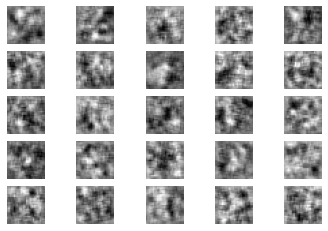

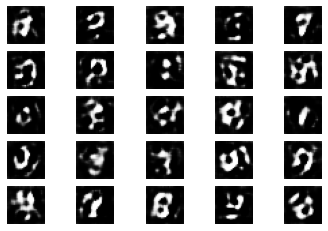

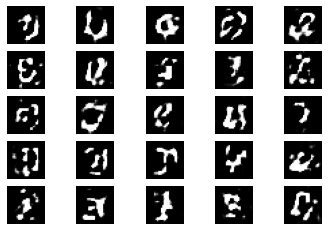

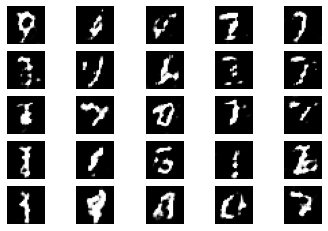

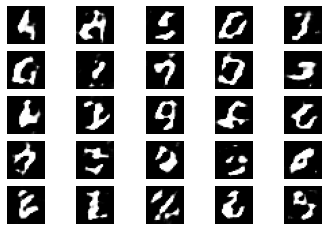

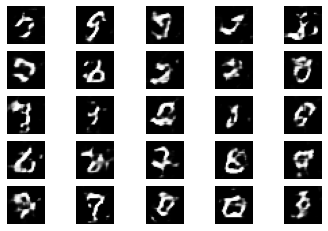

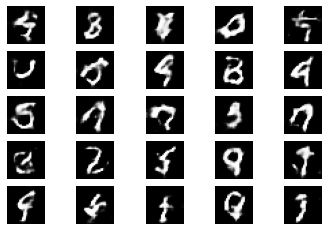

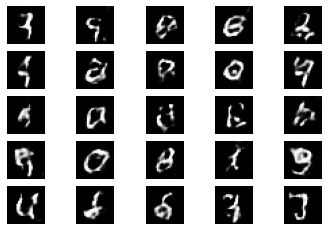

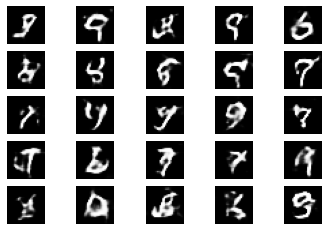

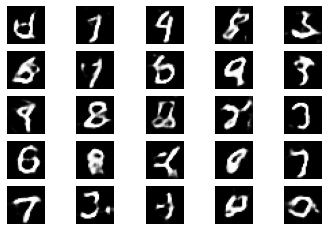

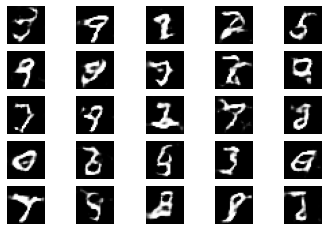

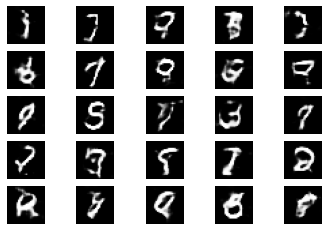

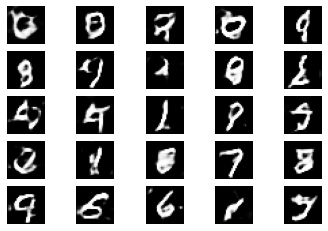

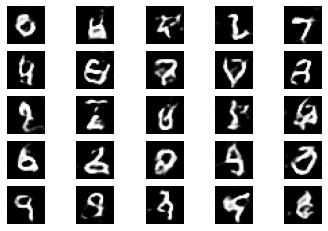

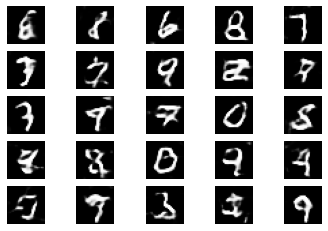

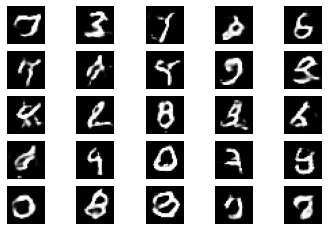

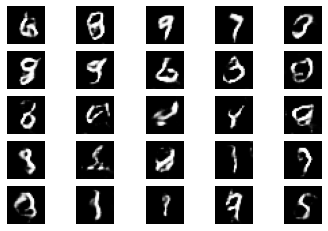

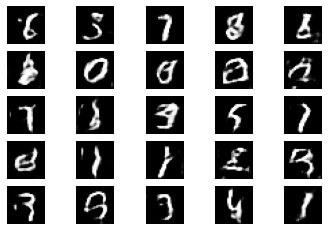

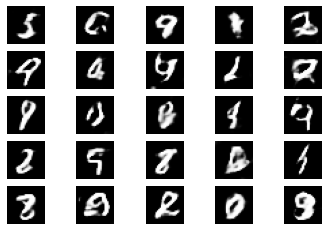

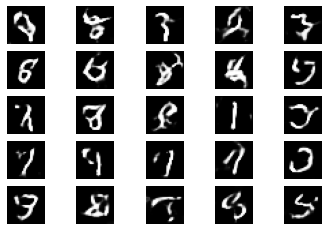

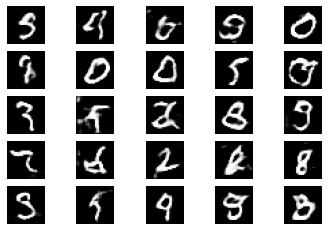

In [23]:
# 4,000번 반복되고(+1을 하는 것에 주의), 배치 크기는 32, 200번마다 결과가 저장됨
gan_train(4001, 32, 200)

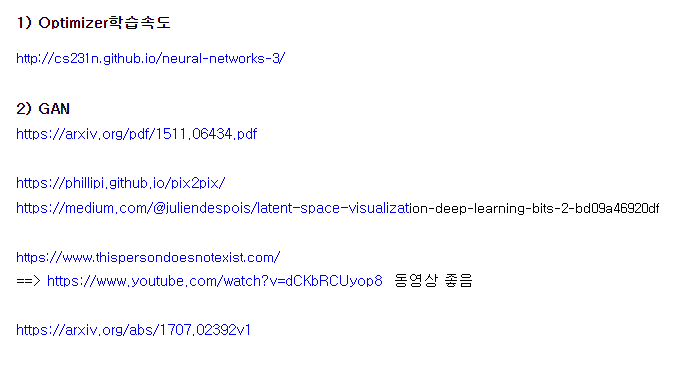

20_GAN.ipynb

In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, initializers, regularizers, metrics

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
       horizontal_flip=True,      # 수평 대칭 이미지를 50% 확률로 만들어 추가
       width_shift_range=0.1,     # 전체 크기의 10% 범위에서 좌우로 이동
       height_shift_range=0.1,    # 마찬가지로 위아래로 이동
                                  # rotation_range=5,
                                  # shear_range=0.7,
                                  # zoom_range=[0.9, 2.2],
                                  # vertical_flip=True,
       fill_mode='nearest') 

In [40]:
train_datagen

In [28]:
train_generator = train_datagen.flow_from_directory(
       './deeplearning/run_project/train',                 # 학습셋이 있는 폴더 위치
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

Found 160 images belonging to 2 classes.


In [30]:
# 테스트셋은 이미지 부풀리기 과정을 진행하지 않음
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
       './deeplearning/run_project/test',                   # 테스트셋이 있는 폴더 위치
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

Found 120 images belonging to 2 classes.


In [33]:
# 앞서 배운 CNN 모델을 만들어 적용하기
model = Sequential()             
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
 
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))
  
# 모델 컴파일  
model.compile(loss='sparse_categorical_crossentropy',
optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

Epoch 1/50
32/32 [==============================] - 3s 79ms/step - loss: 0.1472 - accuracy: 0.9625 - val_loss: 0.0915 - val_accuracy: 0.9500
Epoch 2/50
32/32 [==============================] - 3s 78ms/step - loss: 0.1071 - accuracy: 0.9563 - val_loss: 0.0955 - val_accuracy: 0.9500
Epoch 3/50
32/32 [==============================] - 3s 79ms/step - loss: 0.1187 - accuracy: 0.9812 - val_loss: 0.0813 - val_accuracy: 0.9500
Epoch 4/50
32/32 [==============================] - 3s 79ms/step - loss: 0.1111 - accuracy: 0.9812 - val_loss: 0.1082 - val_accuracy: 0.9500
Epoch 5/50
32/32 [==============================] - 3s 78ms/step - loss: 0.1042 - accuracy: 0.9563 - val_loss: 0.1036 - val_accuracy: 0.9500
Epoch 6/50
32/32 [==============================] - 3s 78ms/step - loss: 0.1119 - accuracy: 0.9688 - val_loss: 0.0944 - val_accuracy: 0.9500
Epoch 7/50
32/32 [==============================] - 2s 78ms/step - loss: 0.1129 - accuracy: 0.9750 - val_loss: 0.1419 - val_accuracy: 0.9500
Epoch 8/50
32

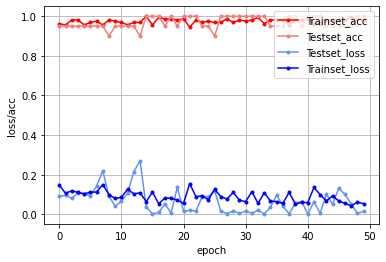

In [39]:
# 모델 실행
history = model.fit_generator(train_generator,
                              steps_per_epoch=32,
                              epochs=50,
                              validation_data=test_generator, validation_steps=4)
  
# 결과를 그래프로 표현하는 부분
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
x_len = np.arange(len(y_loss))  
plt.plot(x_len, acc, marker='.', c="red", label='Trainset_acc')
plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='Testset_acc')
plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')
 
plt.legend(loc='upper right') 
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()

In [ ]:
#vgg16 : https://neurohive.io/en/popular-networks/vgg16/